## Import Statements

In [2]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

## Get Files 
Get file ready from Alpha Vantage API and read into dataframe

In [27]:
api_key = apikey
output_size = 'full'
symbol='AAPL'
url = ("https://www.alphavantage.co/query?"
       "function=TIME_SERIES_DAILY_ADJUSTED&"
       f"symbol={symbol}&"
       f"outputsize={output_size}&"
       f"apikey={api_key}"
       )
response = requests.get(url=url)
response_data = response.json()

In [28]:
df = pd.DataFrame.from_dict(response_data['Time Series (Daily)'], orient="index", dtype=float)
df.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
2023-01-05,127.13,127.7700,124.76,125.02,125.02,80962708.0,0.0,1.0
2023-01-04,126.89,128.6557,125.08,126.36,126.36,89113633.0,0.0,1.0
2023-01-03,130.28,130.9000,124.17,125.07,125.07,112117471.0,0.0,1.0
2022-12-30,128.41,129.9500,127.43,129.93,129.93,77034209.0,0.0,1.0
2022-12-29,127.99,130.4814,127.73,129.61,129.61,75703710.0,0.0,1.0


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5833 entries, 2023-01-05 to 1999-11-01
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   1. open               5833 non-null   float64
 1   2. high               5833 non-null   float64
 2   3. low                5833 non-null   float64
 3   4. close              5833 non-null   float64
 4   5. adjusted close     5833 non-null   float64
 5   6. volume             5833 non-null   float64
 6   7. dividend amount    5833 non-null   float64
 7   8. split coefficient  5833 non-null   float64
dtypes: float64(8)
memory usage: 410.1+ KB


In [30]:
df.index

Index(['2023-01-05', '2023-01-04', '2023-01-03', '2022-12-30', '2022-12-29',
       '2022-12-28', '2022-12-27', '2022-12-23', '2022-12-22', '2022-12-21',
       ...
       '1999-11-12', '1999-11-11', '1999-11-10', '1999-11-09', '1999-11-08',
       '1999-11-05', '1999-11-04', '1999-11-03', '1999-11-02', '1999-11-01'],
      dtype='object', length=5833)

## Data Cleaning 
> Rename index column

> Convert index column to datetime

> Clean up the 7 main column names

In [33]:
# rename index column
df.index.name = 'date'
df.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2023-01-05,127.13,127.7700,124.76,125.02,125.02,80962708.0,0.0,1.0
2023-01-04,126.89,128.6557,125.08,126.36,126.36,89113633.0,0.0,1.0
2023-01-03,130.28,130.9000,124.17,125.07,125.07,112117471.0,0.0,1.0
2022-12-30,128.41,129.9500,127.43,129.93,129.93,77034209.0,0.0,1.0
2022-12-29,127.99,130.4814,127.73,129.61,129.61,75703710.0,0.0,1.0


In [34]:
# convert index column to datetime
df.index = pd.DatetimeIndex(df.index)
df.index

DatetimeIndex(['2023-01-05', '2023-01-04', '2023-01-03', '2022-12-30',
               '2022-12-29', '2022-12-28', '2022-12-27', '2022-12-23',
               '2022-12-22', '2022-12-21',
               ...
               '1999-11-12', '1999-11-11', '1999-11-10', '1999-11-09',
               '1999-11-08', '1999-11-05', '1999-11-04', '1999-11-03',
               '1999-11-02', '1999-11-01'],
              dtype='datetime64[ns]', name='date', length=5833, freq=None)

In [35]:
## clean up the names of the 7 main columns
# remove the preceding number and white space
df.columns = [d.split('. ')[1] for d in df.columns]

In [36]:
# replace the space between a column name with underscore
df.columns = [d.replace(' ', '_') for d in df.columns]
df.head()

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
date,,,,,,,,
2023-01-05,127.13,127.7700,124.76,125.02,125.02,80962708.0,0.0,1.0
2023-01-04,126.89,128.6557,125.08,126.36,126.36,89113633.0,0.0,1.0
2023-01-03,130.28,130.9000,124.17,125.07,125.07,112117471.0,0.0,1.0
2022-12-30,128.41,129.9500,127.43,129.93,129.93,77034209.0,0.0,1.0
2022-12-29,127.99,130.4814,127.73,129.61,129.61,75703710.0,0.0,1.0


In [37]:
# sort according the oldest date
df.sort_index(ascending=True, inplace=True)

# create a returns column that is the difference between two corresponding columns
df['returns'] = df['close'].pct_change(periods=1) * 100

# drop null values
df.dropna(inplace=True)

df.head()

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,returns
date,,,,,,,,,
1999-11-02,78.00,81.69,77.31,80.25,0.609927,3564600.0,0.0,1.0,3.388302
1999-11-03,81.62,83.25,81.00,81.50,0.619427,2932700.0,0.0,1.0,1.557632
1999-11-04,82.06,85.37,80.62,83.62,0.635540,3384700.0,0.0,1.0,2.601227
1999-11-05,84.62,88.37,84.00,88.31,0.671186,3721500.0,0.0,1.0,5.608706
1999-11-08,87.75,97.73,86.75,96.37,0.732444,8490400.0,0.0,1.0,9.126939


In [38]:
# calculate closing price volatility
y = pd.Series(data=df['returns'], index=df.index)
y.head()

date
1999-11-02    3.388302
1999-11-03    1.557632
1999-11-04    2.601227
1999-11-05    5.608706
1999-11-08    9.126939
Name: returns, dtype: float64

## Exploratory Data Analysis

In [39]:
# calculate the daily volatility
y_daily_volatility = y.std()
print(f"The Daily Volatility of {symbol} is {y_daily_volatility}")

The Daily Volatility of AAPL is 3.053113786238628


In [40]:
# calculate the annual volatility
days = 252 # the number of trading days per year
y_annual_volatility = y.std() * np.sqrt(days)
print(f"The Daily Volatility of {symbol} is {y_annual_volatility}")

The Daily Volatility of AAPL is 48.46667881662136


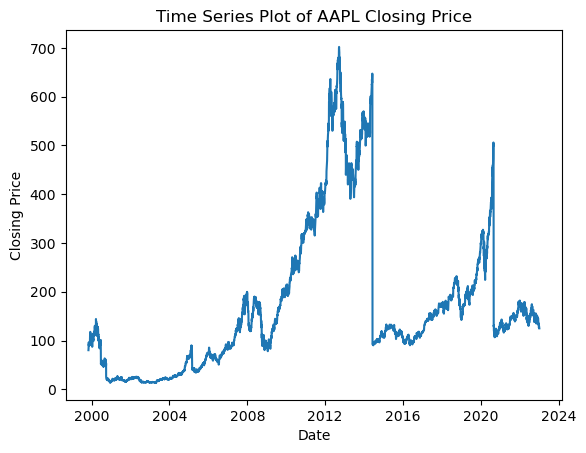

In [41]:
# create figure plot
fig, ax = plt.subplots()
ax.plot(df.index, df['close'], label='close')

# add axis labels
plt.xlabel('Date')
plt.ylabel('Closing Price')

# add title label
plt.title(f'Time Series Plot of {symbol} Closing Price')

# show plot
plt.show()

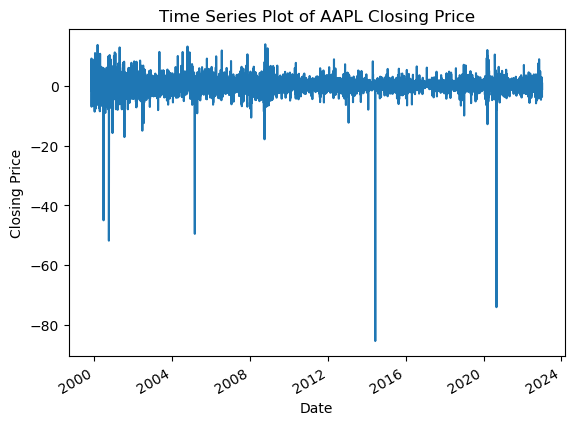

In [42]:
# create figure plot
fig, ax = plt.subplots()
y.plot(ax=ax)

# add axis labels
plt.xlabel('Date')
plt.ylabel('Closing Price')

# add title label
plt.title(f'Time Series Plot of {symbol} Closing Price')

# show plot
plt.show()

Create ACF and PACF plots of the volatility (returns) to help estimate p and q respectively.

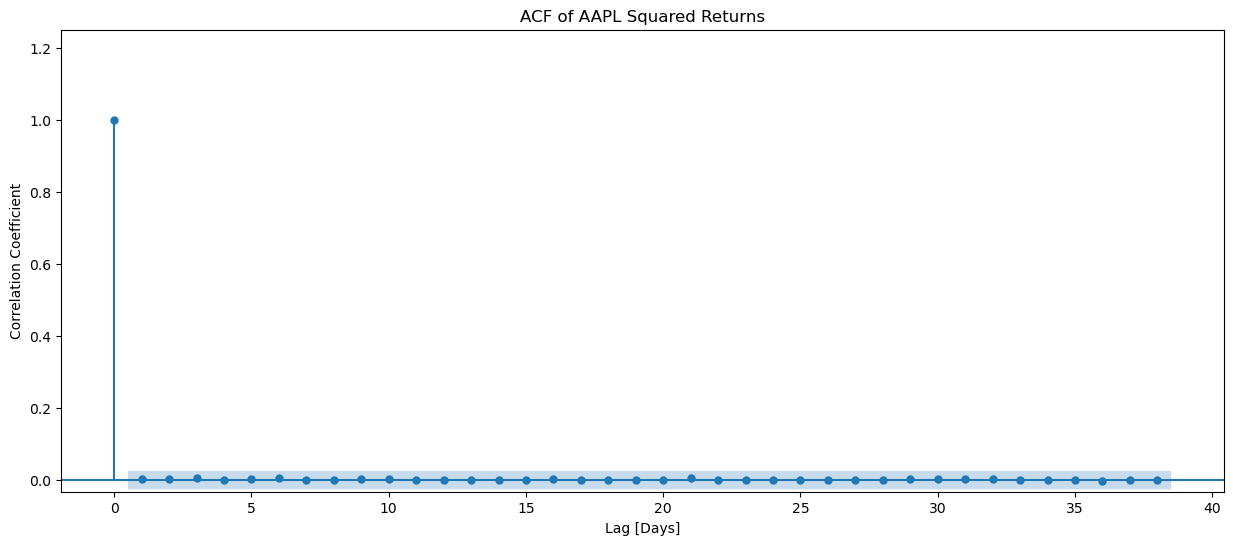

In [43]:
# create figure plot
fig, ax = plt.subplots(figsize=(15,6))
plot_acf(y**2, ax=ax, auto_ylims=True)

# add axis labels
plt.xlabel('Lag [Days]')
plt.ylabel('Correlation Coefficient')

# add title label
plt.title(f'ACF of {symbol} Squared Returns')

# show plot
plt.show()

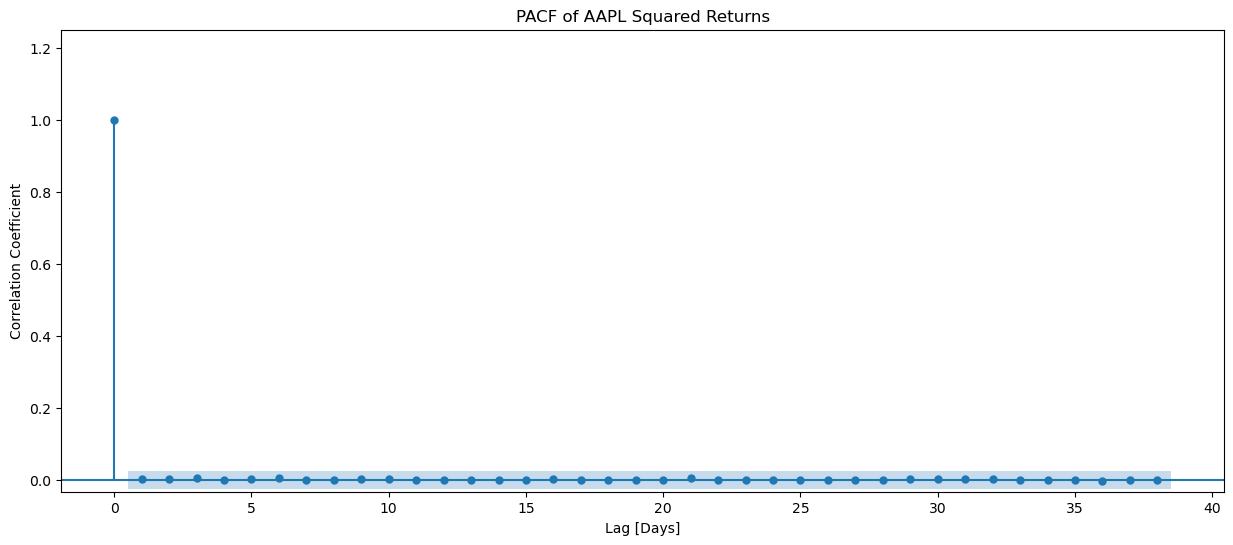

In [44]:
# create figure plot
fig, ax = plt.subplots(figsize=(15,6))
plot_pacf(y**2, ax=ax, auto_ylims=True)

# add axis labels
plt.xlabel('Lag [Days]')
plt.ylabel('Correlation Coefficient')

# add title label
plt.title(f'PACF of {symbol} Squared Returns')

# show plot
plt.show()

From the charts above, the lags, p and q can be assumed to be 1.

## Build Model

In [45]:
# split dataset into train and test dataset. 80% for training and 20% for testing
cutoff = int(len(y)* 0.8)
y_train = y[:cutoff]
y_test = y[cutoff:]

In [46]:
# build and train model
model = arch_model(y_train, p=1, q=1, rescale=False).fit(disp=0)

# view model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -11631.0
Distribution:                  Normal   AIC:                           23270.0
Method:            Maximum Likelihood   BIC:                           23295.8
                                        No. Observations:                 4665
Date:                Fri, Jan 06 2023   Df Residuals:                     4664
Time:                        16:17:51   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0664  5.430e-02      1.223      0.221 [-4.004e-02,  0.173]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.5432      1.711      0.902      0.367   [ -1.810,  4.897]
alpha[1]       0.1222  5.925e-02      2.063  3.915e-02 [6.084e-03,  0.238]
beta[1]        0.7398      0.156      4.737  2.167e-06   [  0.434,  1.046]
==========================================================================

Covariance estimator: robust
"""

Let's create a time series plot with the AAPL returns and the conditional volatility for the model

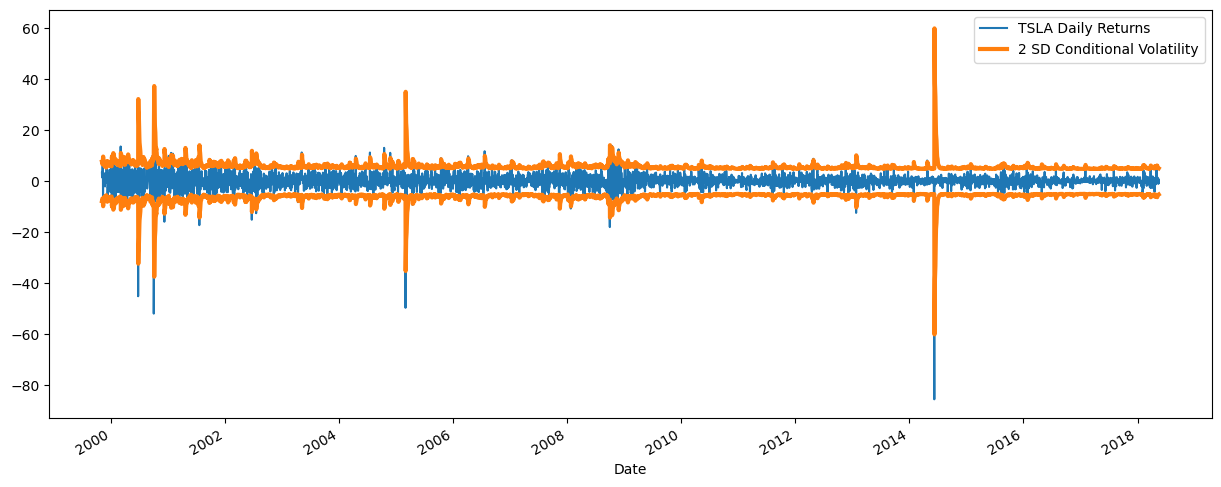

In [47]:
# create figure plot
fig, ax = plt.subplots(figsize=(15,6))

# plot tsla returns
y_train.plot(ax=ax, label='AAPL Daily Returns')

# plot the conditional probability
(2 * model.conditional_volatility).plot(
    ax=ax, color='C1', label='2 SD Conditional Volatility', linewidth=3
)

(-2 * model.conditional_volatility.rename("")).plot(
    ax=ax, color='C1', linewidth=3
)

# add axis label
plt.xlabel('Date')

# add legend
plt.legend();

## Evaluate

In [48]:
# Walk forward validation
prediction = []

# calculate test size
test_size = int(len(y) * 0.2)

# walk forward
for i in range(test_size):
    # create test data
    y_train = y.iloc[:-(test_size - i)]
    
    # train model
    model = arch_model(y_train, p=1, q=1, rescale=False).fit(disp=0)
    
    # generate next prediction
    next_pred = model.forecast(horizon=1, reindex=False).variance.iloc[0,0] ** 0.5
    
    # append to prediction list
    prediction.append(next_pred)
    
# convert predictions list to pandas series
y_wfv = pd.Series(prediction, index=y.tail(test_size).index)
y_wfv.head()

date
2018-05-21    2.518652
2018-05-22    2.506741
2018-05-23    2.490066
2018-05-24    2.483203
2018-05-25    2.470532
dtype: float64

plot the evaluated test data

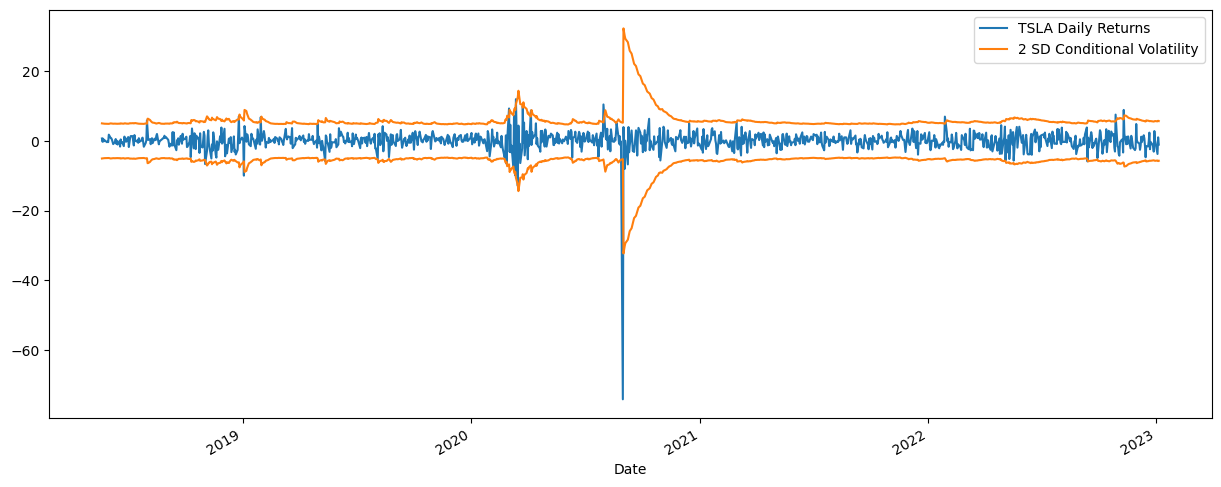

In [49]:
# create figure plot
fig, ax = plt.subplots(figsize=(15,6))

# plot aapl returns for test data
y.tail(test_size).plot(ax=ax, label='AAPL Daily Returns')

# plot the conditional probability
(2 * y_wfv).plot(
    ax=ax, color='C1', label='2 SD Conditional Volatility',
)

(-2 * y_wfv.rename('')).plot(
    ax=ax, color='C1',
)

# add axis label
plt.xlabel('Date')

# add legend
plt.legend();